# Section 1: PyTorch & The Math of Tensors

Everything in Deep Learning is a tensor. A tensor is just a container for numbers, but it comes with superpowers: it can run on a GPU and it knows how to compute its own gradients.

In this notebook, we focus on the **operations that actually matter for Transformers**.

1.  **Shapes & Reshaping**: The most common source of bugs.
2.  **Batch Matrix Multiplication (`bmm`)**: Processing multiple sequences at once.
3.  **`einsum`**: The Swiss Army Knife of tensor operations.
4.  **Dot Product as Similarity**: Visualizing why Attention works.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Always check your device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. The Shape of Things

In Transformers, data usually flows in the shape `(Batch_Size, Sequence_Length, Embedding_Dim)` or `(B, T, C)`.

Let's simulate a batch of data.

In [2]:
B, T, C = 2, 4, 3  # Batch=2, Time=4 tokens, Channels=3 dim

x = torch.randn(B, T, C)
print(f"Original shape: {x.shape}")
print(x)

Original shape: torch.Size([2, 4, 3])
tensor([[[ 0.1339, -1.0556,  1.2186],
         [ 0.7764, -0.1541, -0.5335],
         [-0.2776, -1.0699,  1.9671],
         [-0.9331, -0.4480, -0.5440]],

        [[-0.7280,  1.6318, -0.0986],
         [-0.2242, -0.1566, -0.9781],
         [ 0.8886, -1.2145, -0.4189],
         [-0.2522, -1.2311, -0.2200]]])


### View vs Reshape vs Transpose
Often we need to merge the Batch and Time dimensions to process everything as a long list of tokens.

In [3]:
packed = x.view(B * T, C)
print(f"Packed shape: {packed.shape}")

# To get it back, we must know the original dimensions
unpacked = packed.view(B, T, C)
assert torch.allclose(x, unpacked)
print("Successfully unpacked!")

Packed shape: torch.Size([8, 3])
Successfully unpacked!


## 2. Einstein Summation (`einsum`)

This is the most powerful function in PyTorch. It allows you to describe matrix operations just by their indices. 

General rule: **Repeated indices are summed over.**

### Example: Matrix Multiplication
Standard: $C = A \times B$ where $A \in (I, K)$ and $B \in (K, J)$.
Indices: `ik,kj->ij`

In [7]:
A = torch.randn(2, 3)
B = torch.randn(3, 4)

# Standard Matrix Mul
C_matmul = torch.matmul(A, B)
print(f"C_matmul: {C_matmul}")

# Einsum
C_einsum = torch.einsum('ik,kj->ij', A, B)
print(f"C_einsum: {C_einsum}")

print(f"Match: {torch.allclose(C_matmul, C_einsum)}")

C_matmul: tensor([[-1.4025, -0.7857, -2.3989,  2.5984],
        [ 0.1587,  1.0601,  0.9030, -1.0795]])
C_einsum: tensor([[-1.4025, -0.7857, -2.3989,  2.5984],
        [ 0.1587,  1.0601,  0.9030, -1.0795]])
Match: True


### Why is `einsum` good for Transformers?
Self-Attention involves multiplying logical matrices for every head in every batch item. 

Imagine we want to compute Attention Scores: $Q \times K^T$.
$Q, K$ both have shape `(Batch, Heads, Seq_Len, Dim)` -> `(b, h, t, d)`.

We want the result to be `(Batch, Heads, Seq_Len, Seq_Len)` -> `(b, h, t, t)`.

With `einsum`, we just write the string!

In [8]:
b, h, t, d = 1, 1, 4, 3
Q = torch.randn(b, h, t, d)
K = torch.randn(b, h, t, d)

# 'bhtd,bhSd->bhtS' -> multiply along 'd', keep batch and heads separate.
# Note: I used 'S' for the second sequence length to be explicit, though here S=t.
attention_scores = torch.einsum('bhtd,bhSd->bhtS', Q, K)

print(f"Scores shape: {attention_scores.shape}")

Scores shape: torch.Size([1, 1, 4, 4])


## 3. Dot Product = Similarity

Why do we multiply vectors? The dot product is a measure of how much two vectors point in the same direction.

Let's visualize this.

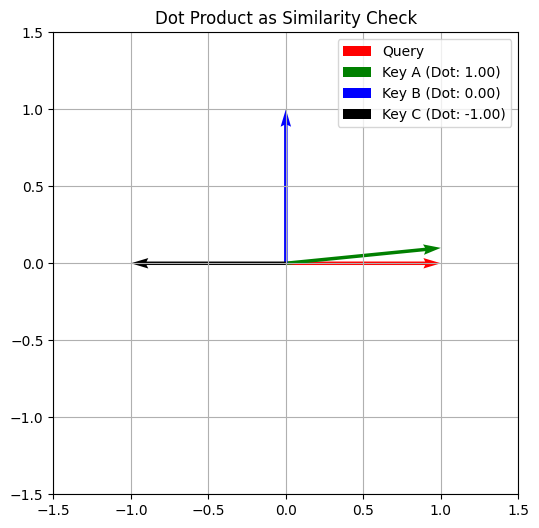

In [9]:
def plot_vector(v, color='b', label=None):
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color=color, label=label)

# Define a "Query" vector
query = np.array([1, 0])  # Points Right

# Define keys
key_A = np.array([1, 0.1])   # Very similar
key_B = np.array([0, 1])     # Orthogonal (No relation)
key_C = np.array([-1, 0])    # Opposite

plt.figure(figsize=(6,6))
plot_vector(query, 'r', 'Query')
plot_vector(key_A, 'g', f'Key A (Dot: {np.dot(query, key_A):.2f})')
plot_vector(key_B, 'b', f'Key B (Dot: {np.dot(query, key_B):.2f})')
plot_vector(key_C, 'k', f'Key C (Dot: {np.dot(query, key_C):.2f})')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid()
plt.legend()
plt.title("Dot Product as Similarity Check")
plt.show()

**Observation:**
*   **Key A**: High dot product $\to$ High Attention Score.
*   **Key B**: Zero dot product $\to$ The vectors are unrelated.

That is all Attention is: **A soft dictionary lookup based on vector similarity.**